In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import urllib.request
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import os
import numpy as np

In [5]:
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(
    inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
    )
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model =  InceptionV3(
        input_shape = (150, 150, 3),
        include_top = False,
        weights     = None
    )

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer =  pre_trained_model.get_layer('mixed7')
last_output=  last_layer.output


train_dir = '/content/drive/MyDrive/OrangButaDataset/train'
validation_dir = '/content/drive/MyDrive/OrangButaDataset/validation'

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

train_generator=  train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )
    

validation_datagen = ImageDataGenerator(rescale=1 / 255)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical'
    )
    
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='sigmoid')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
model.summary()

    


Found 295 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 conv2d_14 (Conv2D)             (None, 16, 16, 64)   76800       ['activation_13[0][0]']          
                                                                                                  
 conv2d_17 (Conv2D)             (None, 16, 16, 96)   82944       ['activation_16[0][0]']          
                                                                                                  
 conv2d_18 (Conv2D)             (None, 16, 16, 64)   16384       ['average_pooling2d_1[0][0]']    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 16, 16, 64)  192         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 64)  192         ['conv2d_14[0][0]']              
 ormalizat

In [6]:
history =  model.fit(
        train_generator,
        epochs=50,
        steps_per_epoch = 8,
        verbose=1,
        validation_data=validation_generator,
        validation_steps = 8,
    )


Epoch 1/50
8/8 [==============================] - 56s 5s/step - loss: 1.4012 - acc: 0.5250 - val_loss: 0.9519 - val_acc: 0.4000
Epoch 2/50
8/8 [==============================] - 17s 2s/step - loss: 0.6634 - acc: 0.7375
Epoch 3/50
8/8 [==============================] - 8s 997ms/step - loss: 0.5752 - acc: 0.7806
Epoch 4/50
8/8 [==============================] - 5s 715ms/step - loss: 0.5070 - acc: 0.8258
Epoch 5/50
8/8 [==============================] - 3s 372ms/step - loss: 0.3375 - acc: 0.9000
Epoch 6/50
8/8 [==============================] - 3s 330ms/step - loss: 0.3901 - acc: 0.8813
Epoch 7/50
8/8 [==============================] - 3s 317ms/step - loss: 0.2966 - acc: 0.8813
Epoch 8/50
8/8 [==============================] - 2s 260ms/step - loss: 0.3186 - acc: 0.8813
Epoch 9/50
8/8 [==============================] - 2s 274ms/step - loss: 0.2994 - acc: 0.9062
Epoch 10/50
8/8 [==============================] - 2s 267ms/step - loss: 0.2226 - acc: 0.9312
Epoch 11/50
8/8 [===================

In [24]:
import os
if os.path.isdir('/content/drive/MyDrive/OrangButaDataset/model') == False:
  os.mkdir(
    '/content/drive/MyDrive/OrangButaDataset/model'
  )
if os.path.isdir('/content/drive/MyDrive/OrangButaDataset/model_tflite') == False:
  os.mkdir(
    '/content/drive/MyDrive/OrangButaDataset/model_tflite'
  )

save_model_path = '/content/drive/MyDrive/OrangButaDataset/model'
tf.saved_model.save(model, save_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('/content/drive/MyDrive/OrangButaDataset/model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/OrangButaDataset/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/OrangButaDataset/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjpy4kb0y/assets


INFO:tensorflow:Assets written to: /tmp/tmpjpy4kb0y/assets


In [19]:

print(train_generator.class_indices)


{'uang_2000': 0, 'uang_20000': 1, 'uang_5000': 2}


In [30]:
def plot_image(img, predictions_array):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label))  
        
    plt.xlabel("{} ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         color='red'))

In [25]:
tflite_model_file = '/content/drive/MyDrive/OrangButaDataset/model.tflite'
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [35]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  interpreter.set_tensor(input_index, images)
  interpreter.invoke()
  prediction = interpreter.get_tensor(output_index)
  class_names = ['Dua Ribu', 'Dua Puluh Ribu', 'Lima Ribu']


Saving 20k.jpeg to 20k (2).jpeg


<class 'numpy.int64'>


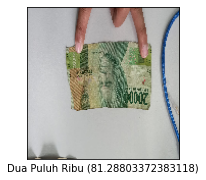

In [36]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(images, prediction)
plt.show()